In [450]:
"""
 unsupervised_ML.ipynb

 Use unsupervised learning to cluster the time series data into different groups.
"""

'\n unsupervised_ML.ipynb\n\n Use unsupervised learning to cluster the time series data into different groups.\n'

#### Libraries

In [106]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, isqrt, ceil
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax, TimeSeriesResampler
from sklearn.metrics import make_scorer, silhouette_score, homogeneity_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit

### Using TS learn K means

In [259]:
# Define common variables
data_folder = '../data/'
seed=42
data_start_date='2023-01-01'

In [260]:
# Load datasets
top500_data_nona = pd.read_pickle(data_folder + 'top500_data_nona.pkl')

In [261]:
# Extract the adjusted close prices
close_prices_adj = top500_data_nona.xs('Adj Close', axis=1, level=0)
close_prices_adj.columns.name = None
close_prices_adj.index.name = None

In [262]:
# Pick top 20 stocks based on latest adjusted close price - Change the logic. The adjusted close price is not a good indicator of the top stocks.
top_stocks=list(close_prices_adj[close_prices_adj.index==close_prices_adj.index.max()].reset_index(drop=True, inplace=False).T.rename(columns={0:'Adj Close'})['Adj Close'].sort_values(ascending=False)[0:20].index)
#top_stocks

In [263]:
# Define top 20 stocks based on inputs from an external source (Investopedia)
top_stocks=['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'GOOG', 'BRK.B', 'META', 'UNH', 'XOM', 'LLY', 'JPM', 'JNJ', 'V', 'PG', 'MA', 'AVGO', 'HD', 'CVX', 'MRK', 'ABBV', 'COST', 'PEP', 'ADBE']
existing_top_stocks = [col for col in top_stocks if col in close_prices_adj.columns] #4 stocks are not in the dataset - BRK.B, ABBV, META, TSLA

In [264]:
# Select the top 20 stocks since 1st Jan 2019
close_prices_adj_top=close_prices_adj[existing_top_stocks][close_prices_adj.index>=data_start_date]
# Save the dataset as a pickle file
close_prices_adj_top.to_pickle(data_folder + 'close_prices_adj_top_unsupervised.pkl')
#close_prices_adj_top.head()

In [265]:
# Define the TS clustering model
iterations=10
distance_metric='dtw' #{“euclidean”, “dtw”, “softdtw”} (default: “euclidean”)
num_clusters=4
model = TimeSeriesKMeans(n_clusters=num_clusters, metric=distance_metric, max_iter=iterations, random_state=seed)

In [273]:
# Preprocess the data
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
X_normalized = scaler.fit_transform(close_prices_adj_top.T.values)
X = close_prices_adj_top.T  # Not using the scaler to plot the values. Comment this out later on, if needed

In [267]:
# Calculate original mean and standard deviation of the time series data for each stock
original_means = dict(np.mean(close_prices_adj_top, axis=0))
original_stds = dict(np.std(close_prices_adj_top, axis=0))

In [268]:
# Fit the model and predict from the data
pred_cluster=model.fit_predict(X)

In [269]:
# Evaluation of the clusters
print(f"Inertia: {model.inertia_}")
print(f"Silhouette Score: {silhouette_score(X, pred_cluster)}") #X[:, :, 0]

Inertia: 133114.39019450458
Silhouette Score: 0.5884923567310694


DTW Scaled: Inertia: 11, Silhouette Score: 0.13 || 
DTW Non-scaled: Inertia: 227879, Silhouette Score: 0.56

SoftDTW Non-scaled: Inertia: 86959127000, Silhouette Score: 0.56

In [430]:
dict_predicted_clusters=dict(zip(close_prices_adj_top.columns, pred_cluster))

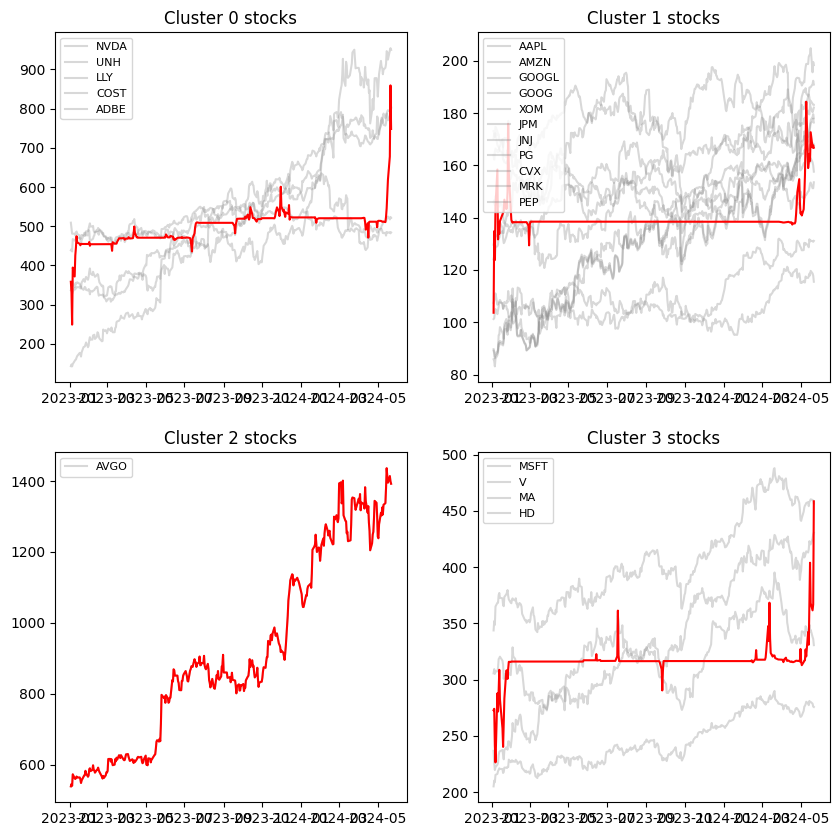

In [431]:
# Plot the clusters
int_sqrt = isqrt(num_clusters)
full_sqrt = sqrt(num_clusters)

if int_sqrt==full_sqrt: #Check if the number of clusters is a perfect square
    nrows=int_sqrt
    ncols=int_sqrt
else:
    nrows=int_sqrt+1
    ncols=ceil(num_clusters/(int_sqrt+1))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

for i in range(num_clusters):
    if nrows==1:
        ax=axs[i]
    else:
        ax=axs[i//ncols, i%ncols]
    
    stocks_in_cluster = [key for key in dict_predicted_clusters if dict_predicted_clusters[key] == i]
    ax.plot(close_prices_adj_top[stocks_in_cluster], color='gray', alpha=0.3)
    ax.plot(close_prices_adj_top[stocks_in_cluster].index, model.cluster_centers_[i].ravel(), 'r')

    ax.set_title(f'Cluster {i} stocks') #{stocks_in_cluster}
    ax.legend(stocks_in_cluster, loc='upper left', fontsize=8)
    #ax.set_xticks([])
    #ax.set_yticks([])


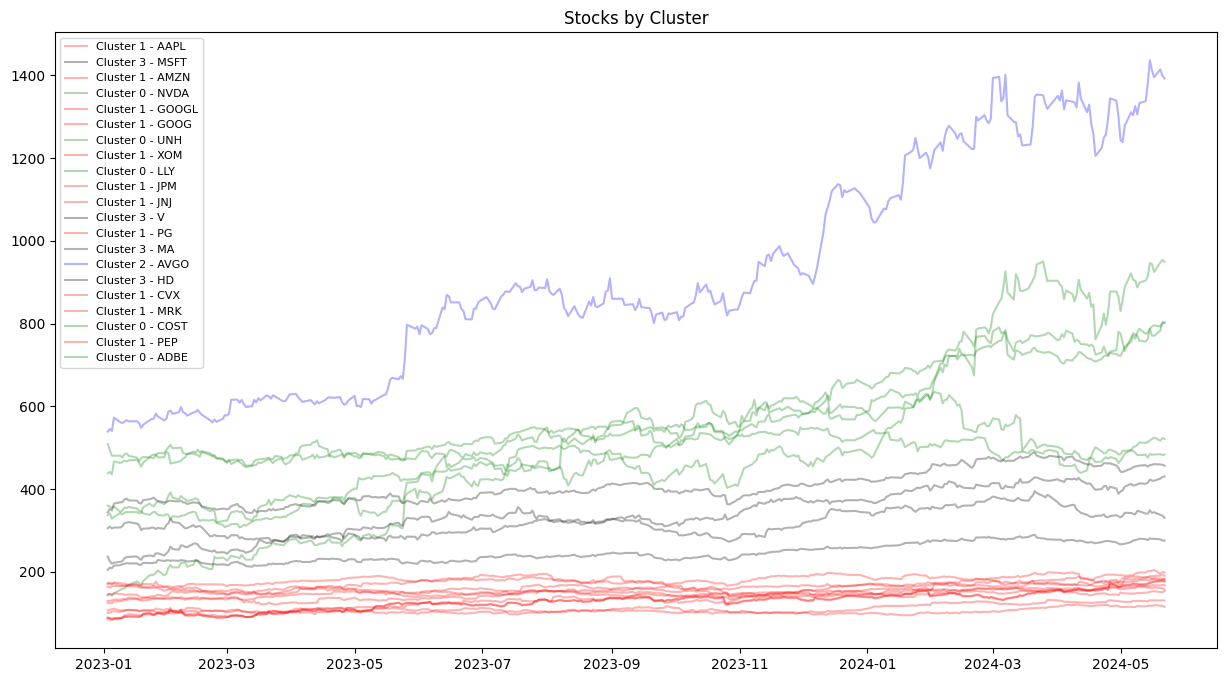

In [448]:
# Number of clusters
num_clusters = len(set(dict_predicted_clusters.values()))


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

dict_color = {0: 'green', 1: 'red', 2: 'blue', 3: 'black'}

# Plot each stock with its cluster color and add a label for the legend
for key in dict_predicted_clusters:
    cluster = dict_predicted_clusters[key]
    ax.plot(close_prices_adj_top[key], color=dict_color[cluster], alpha=0.3, label=f'Cluster {cluster} - {key}')

# Using a dictionary to avoid duplicate labels in the legend and to track them
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper left', fontsize=8)

ax.set_title('Stocks by Cluster')
plt.show()


#### Using pipeline and grid search

##### Note that you will see an error if you use a high value for both n_splits and n_clusters as each sample will be in its own cluster. Silhouette score will not be calculated and scoring function will fail.

In [401]:
# Number of splits for cross-validation
n_splits = 3

# Define the training data
X = close_prices_adj_top.T.to_numpy()
#print("*" * 50)
#print(f"X.shape: {X.shape}")
#print("*" * 50)

# Define the Pipeline
pipeline_kmeans=Pipeline([
            #('normalize', TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)),
            ('normalize', TimeSeriesScalerMinMax(value_range=(-1, 1))),
            ('kmeans', TimeSeriesKMeans(random_state=seed))
    ])

# Define the parameter grid for GridSearchCV
param_grid = {
    'kmeans__n_clusters': [2, 3, 4],  
    'kmeans__metric': ['dtw', 'euclidean'], 
    'kmeans__max_iter': [100, 300] 
}

# Define the scoring function
class SilhouetteScorer:
    def __init__(self):
        self.X_squeeze = None
        self.preds = None

    def silhouette_scorer3(self, model, X, y=None):
        """
        Calculate the silhouette score for the given model and data.
        
        Parameters:
        - model: The unsupervised learning model used for clustering.
        - X: The input data used for clustering.
        - y: (optional) The true labels for the input data (if available).
        
        Returns:
        - score: The silhouette score calculated for the clustering model and data.
        
        Note:
        - If you use a high value for both n_splits and n_clusters, each sample will be in its own cluster,
          resulting in an error and the scoring function will fail.
        - The silhouette score will not be calculated in this case and the function will return 0.
        """

        # Change the shape of X to 2D and remove the singleton dimension.
        # This is required for silhouette_score since it expects a 2D array.
        # Make predictions using the model and calculate the silhouette score.
        self.X_squeeze = np.squeeze(X)
        self.preds = model.fit_predict(self.X_squeeze)
        
        # Calculate the silhouette score
        try:
            score = silhouette_score(self.X_squeeze, self.preds, metric='euclidean')
        except Exception as e:
            print("Error in silhouette_score:", e)
            print("self.pred=", self.preds, "model=", model)
            score = 0

        # Return the silhouette score
        return score if len(set(self.preds)) > 1 else 0
    
# Instantiate the scorer
scorer = SilhouetteScorer()

# Create the grid search object
grid_search_kmeans = GridSearchCV(
    estimator=pipeline_kmeans,  # Initialize with any value; GridSearchCV will override
    param_grid=param_grid,
    cv=TimeSeriesSplit(n_splits=n_splits),
    scoring=scorer.silhouette_scorer3,  # Maximizing silhouette score is equivalent to minimizing its negative
    #refit=False  # Avoid refitting the best estimator to the whole dataset
)

# Fit the grid search to the training data
grid_search_kmeans.fit(X)

# Best parameters found by grid search
print("Best parameters found:", grid_search_kmeans.best_params_)
# Best score
print("Best score:", grid_search_kmeans.best_score_)


In [398]:
grid_search_kmeans.best_estimator_

Pipeline(steps=[('normalize', TimeSeriesScalerMinMax(value_range=(-1, 1))),
                ('kmeans',
                 TimeSeriesKMeans(max_iter=100, n_clusters=2,
                                  random_state=42))])

In [393]:
# Get all the results across the grid search
grid_search_kmeans.cv_results_ 

{'mean_fit_time': array([0.36486808, 0.36393825, 0.41318345, 0.01102614, 0.00434844,
        0.01041921, 0.35943762, 0.41122588, 0.40704926, 0.00698773,
        0.00875107, 0.0099647 ]),
 'std_fit_time': array([0.195196  , 0.17171255, 0.21375123, 0.00779667, 0.00614962,
        0.00736749, 0.17147881, 0.15818874, 0.20371317, 0.00139967,
        0.00151363, 0.00156354]),
 'mean_score_time': array([0.13428942, 0.13085612, 0.17475152, 0.        , 0.01197561,
        0.        , 0.14247775, 0.14200401, 0.1405278 , 0.00500059,
        0.00632445, 0.00810345]),
 'std_score_time': array([1.24083042e-02, 2.28788461e-03, 1.84214112e-02, 0.00000000e+00,
        4.82635369e-03, 0.00000000e+00, 6.87234825e-03, 1.92918032e-03,
        6.61505864e-03, 1.46971083e-06, 2.62302723e-04, 8.27904762e-04]),
 'param_kmeans__max_iter': masked_array(data=[100, 100, 100, 100, 100, 100, 300, 300, 300, 300, 300,
                    300],
              mask=[False, False, False, False, False, False, False, False,

##### X vs X normalized

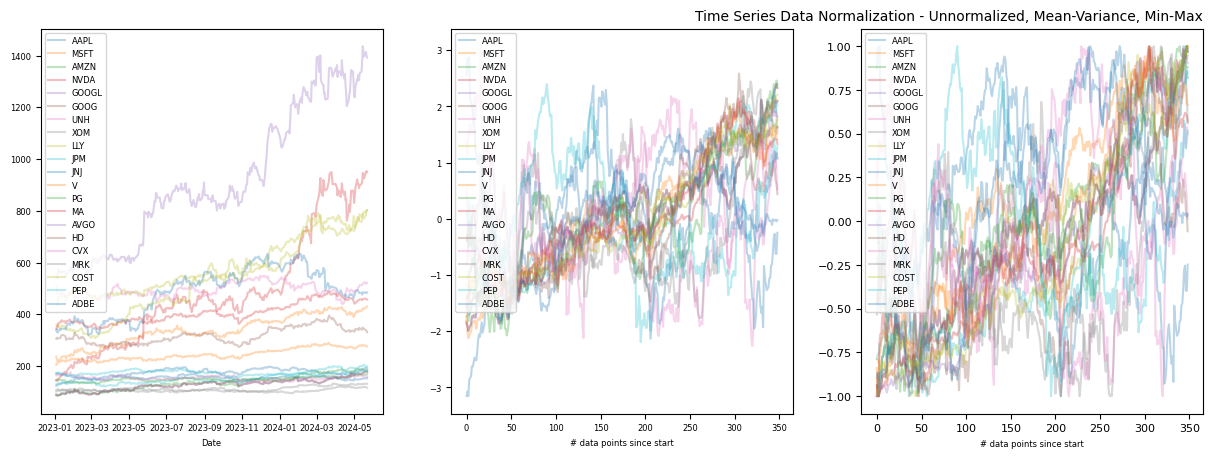

In [391]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].plot(close_prices_adj_top, alpha=0.3)
plt.legend(close_prices_adj_top.columns, loc='upper left', fontsize=8)
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)

ax[1].plot(np.array([scaler.fit_transform(np.array(close_prices_adj_top[stock].values).reshape(1, -1)).flatten()
                                           for stock in close_prices_adj_top.columns]
                                           ).T, alpha=0.3);

scaler=TimeSeriesScalerMinMax(value_range=(-1, 1))
ax[2].plot(np.array([
    scaler.fit_transform(np.array(close_prices_adj_top[stock].values).reshape(1, -1)).flatten()
    for stock in close_prices_adj_top.columns
]).T, alpha=0.3);
ax[0].legend(close_prices_adj_top.columns, loc='upper left', fontsize=6)
ax[1].legend(close_prices_adj_top.columns, loc='upper left', fontsize=6)
ax[2].legend(close_prices_adj_top.columns, loc='upper left', fontsize=6)
for _ in ax:
    _.tick_params(axis='x', labelsize=6)  
    _.tick_params(axis='y', labelsize=6)  
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Time Series Data Normalization - Unnormalized, Mean-Variance, Min-Max', loc="right", fontsize=10)
ax[0].set_xlabel('Date', fontsize=6)
ax[1].set_xlabel('# data points since start', fontsize=6)
ax[2].set_xlabel('# data points since start', fontsize=6)
plt.show();

### Using a different approach - Kmeans on aggregated data

In [372]:
#Calculating annual mean returns and variances - There are typically 252 trading days in a year
returns = close_prices_adj_top.pct_change().mean() * 252
variance = close_prices_adj_top.pct_change().std() * sqrt(252)
returns.columns = ["Returns"]
variance.columns = ["Variance"]
#Concatenating the returns and variances into a single data-frame
ret_var = pd.concat([returns, variance], axis = 1).dropna()
ret_var.columns = ["Returns","Variance"]

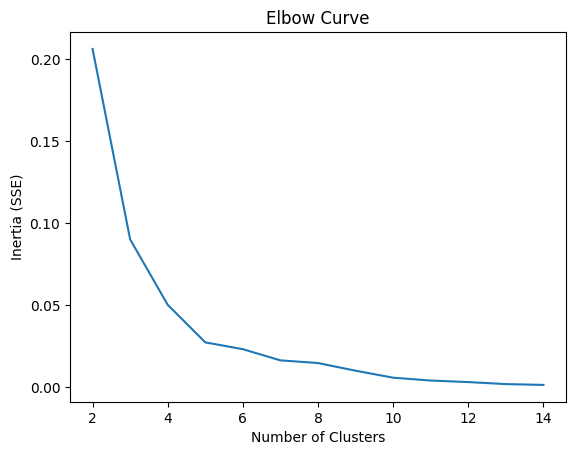

In [378]:
X =  ret_var.values #Converting ret_var into nummpy array
sse = []
for k in range(2,15):
    
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    
    sse.append(kmeans.inertia_) #SSE for each n_clusters
plt.plot(range(2,15), sse)
plt.title("Elbow Curve")
# Add x and y axis labels
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (SSE)") # Lower inertia is better
plt.show()

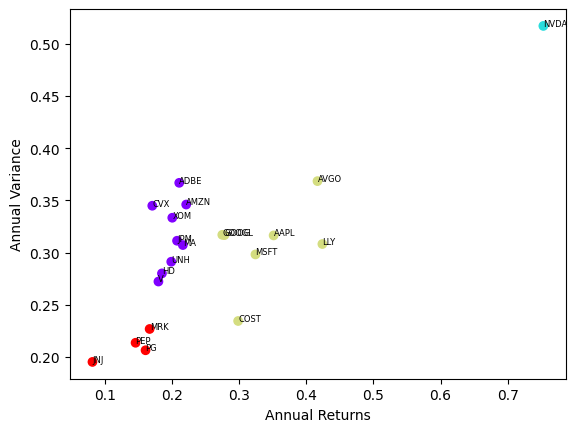

In [376]:
kmeans = KMeans(n_clusters = 4).fit(X)
centroids = kmeans.cluster_centers_
# Plot the data points with the cluster colors
plt.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap ="rainbow")
# Add x and y axis labels
plt.xlabel("Annual Returns")
plt.ylabel("Annual Variance")
# Add labels to the points
for i in range(len(X)):
    plt.text(X[i][0], X[i][1], ret_var.index[i], size=6)
plt.show()

In [379]:
print(returns.idxmax())
ret_var.drop("NVDA", inplace =True)

NVDA


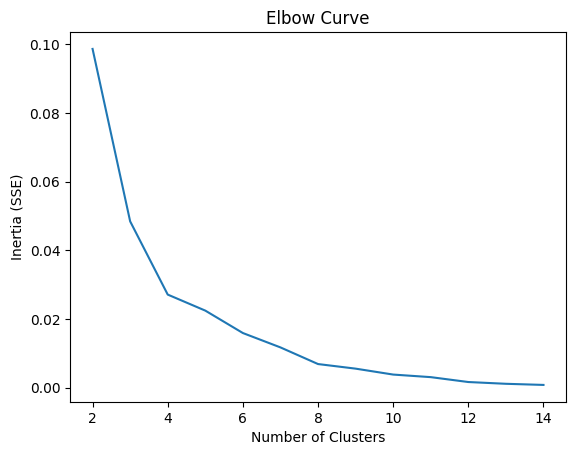

In [380]:
# Replotting elbow curve with out lier removed
X = ret_var.values
sse = []
for k in range(2,15):
    
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    
    sse.append(kmeans.inertia_) #SSE for each n_clusters
plt.plot(range(2,15), sse)
plt.title("Elbow Curve")
# Add x and y axis labels
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (SSE)") # Lower inertia is better
plt.show()

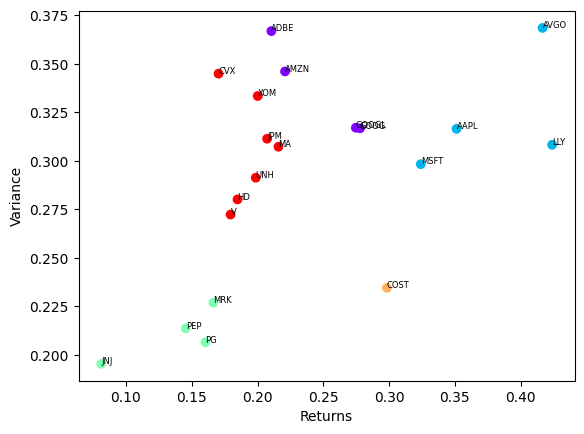

In [382]:
X = ret_var.values
kmeans =KMeans(n_clusters = 5).fit(X)
centroids = kmeans.cluster_centers_
# Plot the data points with the cluster colors
plt.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap ="rainbow")
# Add x and y axis labels
plt.xlabel("Returns")
plt.ylabel("Variance")
for i in range(len(X)):
    plt.text(X[i][0], X[i][1], ret_var.index[i], size=6)
plt.show()